<a href="https://colab.research.google.com/github/regain001/Machine-Learning/blob/master/Paper%20Review%20Analysis/Paper-Review-Analysis_(Ternary-Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ternary Classification (label : Orientation)

### **`Applied Hyper parameter tuning with k-Fold Cross-Validation in 4 different types of classifier algorithms`**
*SVM, Random Forest, Multinomial Naive Bayes, Logistic Regression*

*Using Count Vectorizer Technic*


**`Label : Orientation`**

**`Classification : Ternary`**


#### **Data Preprocessing**

In [0]:
import json

!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


382


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13e14d2668>]],
      dtype=object)

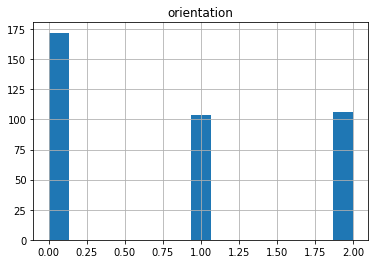

In [0]:
data=[]
for item in dataStore['paper']:

  primary_decision = item['preliminary_decision']
  item_reviews = item['review']

  for item in item_reviews:
    ls = []
    # orientation = item['orientation']
    evaluation = item['evaluation']
    confidence = item['confidence']
    remarks = item['remarks']
    text = item['text']

    label = item['orientation']

    if(label == '1' or label == '2') : label = 2
    elif( label == '0'): label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      ls.append(int(label))
      ls.append(int(evaluation))
      ls.append(int(confidence or 0))
      # ls.append(primary_decision)
      ls.append(text)

    # if(text!=""):ls.append("text")
    # else: ls.append("no text")

    # if(remarks!=""):ls.append("remarks")
    # else: ls.append("no remarks")

      data.append(ls)

print(len(data))

import pandas as pd
data = pd.DataFrame(data, columns=['orientation', 'evaluation', 'confidence', 'texts'])
# data.hist(figsize=(10,10), bins = 15)
# data.hist(column='orientation', bins = 15)
# print(len(labels))
# dt =  pd.DataFrame(labels, columns=['Ternary Classification : Orientation'])
# dt.hist()
data[5:8]
data.hist(column='orientation', bins = 15)

In [0]:
target = data.orientation
inputs = data
# data.head()
# inputs.head()

In [0]:
# One hot encoding
# dummies = pd.get_dummies(inputs.decision)
# dummies.head(2)

In [0]:
# inputs = pd.concat([inputs,dummies],axis='columns')
# inputs.head(3)

In [0]:
# inputs.columns[inputs.isna().any()]
data.groupby('orientation').describe()

evaluation                                ... confidence                    
                 count      mean       std  min  25%  ...        min  25%  50%  75%  max
orientation                                           ...                               
0                172.0 -1.075581  1.065178 -2.0 -2.0  ...        0.0  3.0  4.0  4.0  5.0
1                104.0  0.615385  1.117449 -2.0  0.0  ...        1.0  3.0  4.0  4.0  5.0
2                106.0  1.622642  0.576572  0.0  1.0  ...        1.0  3.0  3.0  4.0  5.0

[3 rows x 16 columns]

#### **Applying different Classifier Algorithms**

In [0]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    }

    # 'naive_bayes_gaussian': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },
    # 'decision_tree': {
    #     'model': DecisionTreeClassifier(),
    #     'params': {
    #         'criterion': ['gini','entropy'],
    #     }
    # }  
}

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, f1_score, auc
from sklearn.model_selection import GridSearchCV, train_test_split

scores = []
X_train, X_test, y_train, y_test = train_test_split(inputs.texts,target, test_size = .20)

v = CountVectorizer()
X_train_count = v.fit_transform(X_train.values)
X_test_count = v.transform(X_test.values)
X_test_count = v.transform(X_test)


for model_name, mp in model_params.items():
    
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_count, y_train)
    clf.score(X_test_count, y_test)

    y_predicted = clf.predict(X_test_count)
    conf_matx = confusion_matrix(y_test, y_predicted)

    # define pos label in order to calculate precision, recall, F1-Score, ROC 
    # for a ##specific Class
    positive_lbl = 2
    fpr, tpr, _ = roc_curve(y_test, y_predicted, pos_label = positive_lbl)
    roc_auc = auc(fpr, tpr)

    precision = precision_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    recall = recall_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    f1_scor = f1_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'c_matrix': conf_matx ,
        'roc_auc' : roc_auc,
        'precision' : precision,
        'recall' : recall,
        'f1_score' : f1_scor,
        'tpr' : tpr,
        'fpr' : fpr
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params', 'c_matrix', 'roc_auc', 
                                  'precision', 'recall', 'f1_score', 'tpr', 'fpr'])
df[['model','best_score','best_params']]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binar

,model,best_score,best_params
0,svm,0.557377,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.501639,{'n_estimators': 10}
2,logistic_regression,0.557377,{'C': 1}
3,naive_bayes_multinomial,0.514754,{}


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

c_matx = df['c_matrix']
roc_auc = df['roc_auc']
tpr =  df['tpr']
fpr = df['fpr']

def plot_roc(roc_index, title):
  plt.figure()
  lw = 2
  plt.plot(fpr[roc_index], tpr[roc_index], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[roc_index])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC : '+title)
  plt.legend(loc="lower right")
  plt.show()


def plot_cmatricx(c_matx_index, title):
  plt.figure(figsize = (5,4))
  sn.heatmap(c_matx[c_matx_index], annot=True)
  plt.title('Confusion Matricx : '+ title)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

def otherValues(index):
  print('Accuracy :', df['best_score'][index])
  print('Precision :', df['precision'][index])
  print('Recall :', df['recall'][index])
  print('F1-Score :', df['f1_score'][index])

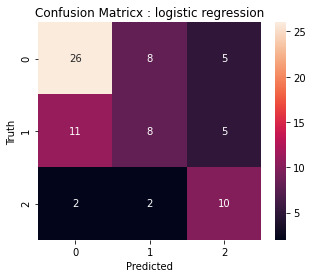

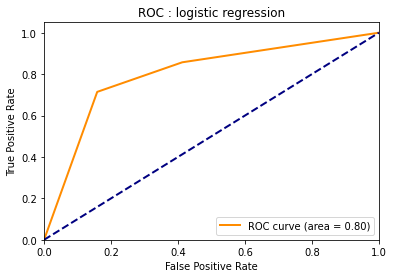

Accuracy : 0.5573770491803278
Precision : 0.5370370370370371
Recall : 0.5714285714285715
F1-Score : 0.5452847805788982


In [0]:
title = 'logistic regression'
index = 2
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

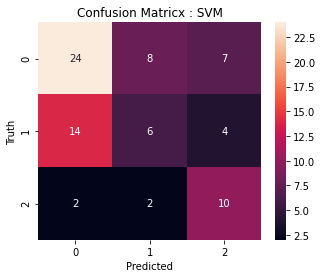

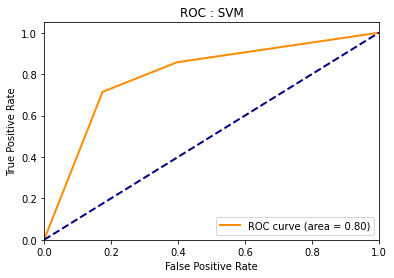

Accuracy : 0.5573770491803278
Precision : 0.48373015873015873
Recall : 0.5265567765567766
F1-Score : 0.4930078360458107


In [0]:
title = 'SVM'
index = 0
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

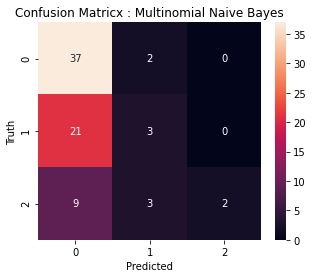

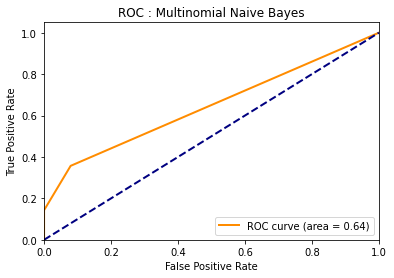

Accuracy : 0.5147540983606558
Precision : 0.6424129353233831
Recall : 0.40552503052503047
F1-Score : 0.37853773584905664


In [0]:
title = 'Multinomial Naive Bayes'
index = 3
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

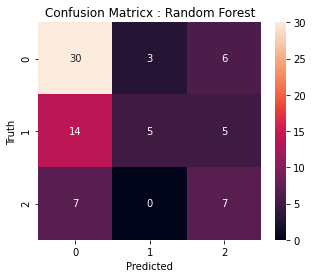

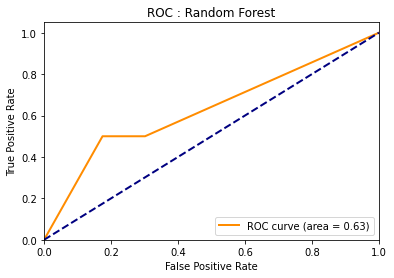

Accuracy : 0.5016393442622951
Precision : 0.534041394335512
Recall : 0.49252136752136755
F1-Score : 0.47222222222222227


In [0]:
title = 'Random Forest'
index = 1
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

In [0]:
dir(clf)

### Analyze using Global Vector(**GloVe**) & **LSTM**

In [0]:
import json
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
# vocab_size = 25000
embedding_dim = 100 # 16 dimentions
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('spanish') 
print(stopwords)

texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" 
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['orientation']

    if( label == '1' or label == '2') : label = 2
    elif( label == '0'): label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):

      # for word in stopwords:
      #   token = " " + word + " " ; 
      #   text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts))
print(len(texts)) 

random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index)

# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

[[0, 1, 4, 'accept', 'text', 'no remarks'], [1, 1, 4, 'accept', 'text', 'no remarks'], [1, 1, 5, 'accept', 'text', 'no remarks'], [1, 2, 4, 'accept', 'text', 'no remarks'], [0, 2, 4, 'accept', 'no text', 'no remarks'], [0, 2, 4, 'accept', 'text', 'no remarks'], [1, 2, 4, 'accept', 'text', 'no remarks'], [1, 2, 3, 'accept', 'text', 'no remarks'], [-1, 0, 3, 'accept', 'text', 'no remarks'], [2, 2, 4, 'accept', 'text', 'remarks'], [-1, -2, 2, 'accept', 'text', 'no remarks'], [1, 2, 4, 'accept', 'text', 'no remarks'], [0, 2, 4, 'accept', 'text', 'no remarks'], [1, 2, 5, 'accept', 'text', 'no remarks'], [0, -1, 4, 'probably reject', 'text', 'no remarks'], [-1, -2, 4, 'probably reject', 'text', 'no remarks'], [-1, 1, 4, 'probably reject', 'text', 'no remarks'], [-1, -2, 5, 'probably reject', 'text', 'remarks'], [0, 2, 4, 'probably reject', 'text', 'no remarks'], [0, 1, 4, 'accept', 'text', 'no remarks'], [1, 2, 4, 'accept', 'text', 'no remarks'], [0, 1, 5, 'accept', 'text', 'no remarks'], [1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6562c10710>]],
      dtype=object)

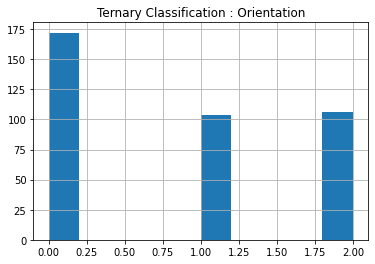

In [30]:
import pandas as pd

data=[]
for item in dataStore['paper']:

  primary_decision = item['preliminary_decision']
  item_reviews = item['review']

  for item in item_reviews:
    ls = []
    orientation = item['orientation']
    evaluation = item['evaluation']
    confidence = item['confidence']
    remarks = item['remarks']
    text = item['text']

    ls.append(int(orientation))
    ls.append(int(evaluation))
    ls.append(int(confidence or 0))
    ls.append(primary_decision)

    if(text!=""):ls.append("text")
    else: ls.append("no text")

    if(remarks!=""):ls.append("remarks")
    else: ls.append("no remarks")

    data.append(ls)

print(data)
  
data = pd.DataFrame(data, columns=['orientation', 'evaluation', 'confidence', 'decision', 'texts', 'remarks'])
# data.hist(figsize=(10,10), bins = 15)
# data.hist(column='orientation', bins = 15)
print(len(labels))
dt =  pd.DataFrame(labels, columns=['Ternary Classification : Orientation'])
dt.hist()

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [26]:
import tensorflow_addons as tfa

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        #tf.math.confusion_matrix(labels, predictions,name=None),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=3)

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         544600    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 996, 16)           8016      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 554,745
Trainable params: 10,145
Non-trainable params: 544,600
_________________________________________________________________
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Training Complete


4/4 - 0s - loss: 0.4622 - accuracy: 0.3043 - precision: 0.5652 - recall: 1.0000 - roc_curve: 0.5000 - FP: 50.0000 - FN: 0.0000e+00 - TP: 65.0000 - TN: 0.0000e+00 - f1_score: 0.6190
Test loss: 0.46216416358947754
Test accuracy: 0.30434781312942505


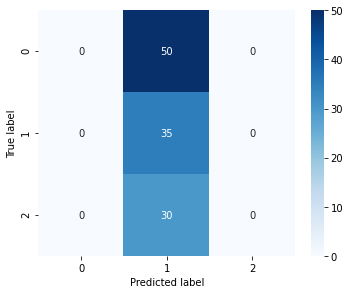

[[ 0 50  0]
 [ 0 35  0]
 [ 0 30  0]]


In [27]:
import matplotlib.pyplot as plt
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

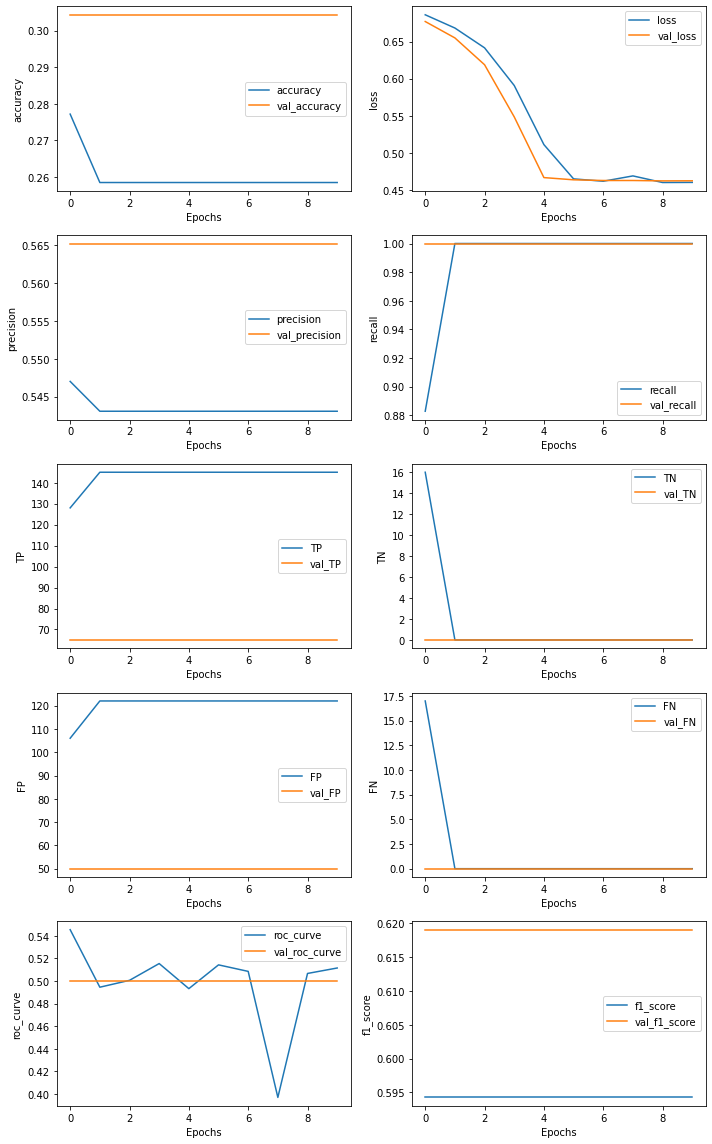

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


# Ternary Classification (label : Evaluation)

### **`Applied Hyper parameter tuning with k-Fold Cross-Validation in 4 different types of classifier algorithms`**
*SVM, Random Forest, Multinomial Naive Bayes, Logistic Regression*

*Using Count Vectorizer Technic*

**`Label : Evaluation`**

**`Classification : Ternary`**


#### **Data Preprocessing**

In [0]:
import json

!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


382


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13e61464a8>]],
      dtype=object)

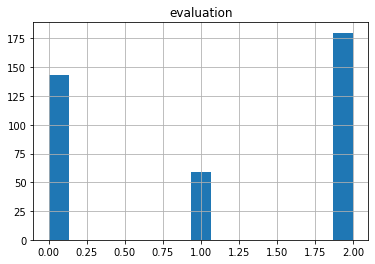

In [0]:
data=[]
for item in dataStore['paper']:

  primary_decision = item['preliminary_decision']
  item_reviews = item['review']

  for item in item_reviews:
    ls = []
    orientation = item['orientation']
    # evaluation = item['evaluation']
    confidence = item['confidence']
    remarks = item['remarks']
    text = item['text']

    label = item['evaluation']

    if(label == '1' or label == '2') : label = 2
    elif( label == '0'): label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      ls.append(int(label))
      ls.append(int(orientation))
      ls.append(int(confidence or 0))
      # ls.append(primary_decision)
      ls.append(text)

    # if(text!=""):ls.append("text")
    # else: ls.append("no text")

    # if(remarks!=""):ls.append("remarks")
    # else: ls.append("no remarks")

      data.append(ls)

print(len(data))

import pandas as pd
data = pd.DataFrame(data, columns=['evaluation', 'orientation', 'confidence', 'texts'])
# data.hist(figsize=(10,10), bins = 15)
# data.hist(column='orientation', bins = 15)
# print(len(labels))
# dt =  pd.DataFrame(labels, columns=['Ternary Classification : Orientation'])
# dt.hist()
data[5:8]
data.hist(column='evaluation', bins = 15)

In [0]:
target = data.evaluation
inputs = data
# inputs = data.drop(['confidence'], axis = 'columns')
# data.head()
# inputs.head()

In [0]:
# One hot encoding
# dummies = pd.get_dummies(inputs.decision)
# dummies.head(2)

In [0]:
# inputs = pd.concat([inputs,dummies],axis='columns')
# inputs.head(3)

In [0]:
inputs.columns[inputs.isna().any()]
data.groupby('evaluation').describe()

orientation                                ... confidence                    
                 count      mean       std  min  25%  ...        min  25%  50%  75%  max
evaluation                                            ...                               
0                143.0 -1.111888  0.582671 -2.0 -1.0  ...        0.0  3.0  4.0  4.0  5.0
1                 59.0 -0.474576  0.703585 -2.0 -1.0  ...        1.0  3.0  4.0  4.0  5.0
2                180.0  0.561111  0.763437 -1.0  0.0  ...        1.0  3.0  4.0  4.0  5.0

[3 rows x 16 columns]

#### **Applying different Classifier Algorithms**

In [0]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    }

    # 'naive_bayes_gaussian': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },
    # 'decision_tree': {
    #     'model': DecisionTreeClassifier(),
    #     'params': {
    #         'criterion': ['gini','entropy'],
    #     }
    # }  
}

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, f1_score, auc
from sklearn.model_selection import GridSearchCV

scores = []
X_train, X_test, y_train, y_test = train_test_split(inputs.texts,target, test_size = .20)

v = CountVectorizer()
X_train_count = v.fit_transform(X_train.values)
X_test_count = v.transform(X_test.values)
X_test_count = v.transform(X_test)


for model_name, mp in model_params.items():
    
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_count, y_train)
    clf.score(X_test_count, y_test)

    y_predicted = clf.predict(X_test_count)
    conf_matx = confusion_matrix(y_test, y_predicted)

    # define pos label in order to calculate precision, recall, F1-Score, ROC 
    # for a ##specific Class
    positive_lbl = 2
    fpr, tpr, _ = roc_curve(y_test, y_predicted, pos_label = positive_lbl)
    roc_auc = auc(fpr, tpr)

    precision = precision_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    recall = recall_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    f1_scor = f1_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'c_matrix': conf_matx ,
        'roc_auc' : roc_auc,
        'precision' : precision,
        'recall' : recall,
        'f1_score' : f1_scor,
        'tpr' : tpr,
        'fpr' : fpr
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params', 'c_matrix', 'roc_auc', 
                                  'precision', 'recall', 'f1_score', 'tpr', 'fpr'])
df[['model','best_score','best_params']]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binar

,model,best_score,best_params
0,svm,0.609836,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.557377,{'n_estimators': 10}
2,logistic_regression,0.606557,{'C': 5}
3,naive_bayes_multinomial,0.547541,{}


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

c_matx = df['c_matrix']
roc_auc = df['roc_auc']
tpr =  df['tpr']
fpr = df['fpr']

def plot_roc(roc_index, title):
  plt.figure()
  lw = 2
  plt.plot(fpr[roc_index], tpr[roc_index], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[roc_index])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC : '+title)
  plt.legend(loc="lower right")
  plt.show()


def plot_cmatricx(c_matx_index, title):
  plt.figure(figsize = (5,4))
  sn.heatmap(c_matx[c_matx_index], annot=True)
  plt.title('Confusion Matricx : '+ title)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

def otherValues(index):
  print('Accuracy :', df['best_score'][index])
  print('Precision :', df['precision'][index])
  print('Recall :', df['recall'][index])
  print('F1-Score :', df['f1_score'][index])


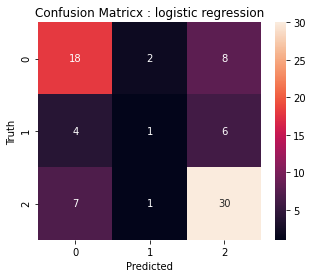

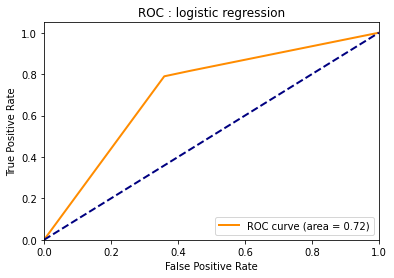

Accuracy : 0.6065573770491803
Precision : 0.5175026123301986
Recall : 0.5077466393255867
F1-Score : 0.49887319925830836


In [0]:
title = 'logistic regression'
index = 2
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

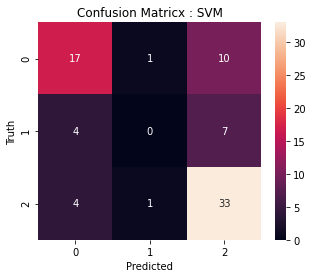

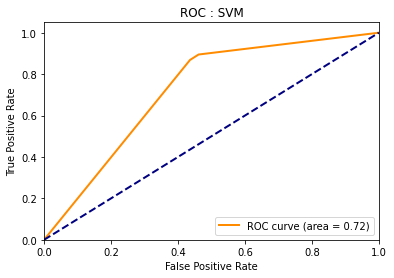

Accuracy : 0.6098360655737706
Precision : 0.4466666666666667
Recall : 0.49185463659147866
F1-Score : 0.4638364779874214


In [0]:
title = 'SVM'
index = 0
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

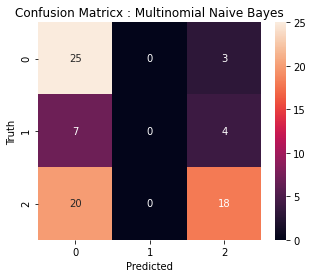

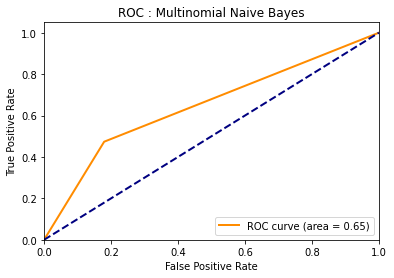

Accuracy : 0.5475409836065573
Precision : 0.4002564102564103
Recall : 0.4555137844611529
F1-Score : 0.3988095238095238


In [0]:
title = 'Multinomial Naive Bayes'
index = 3
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

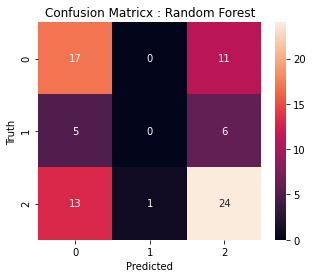

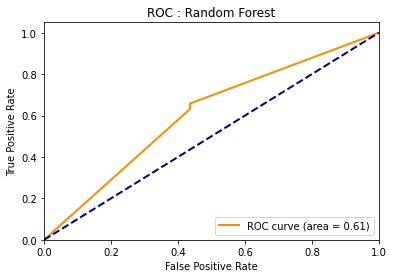

Accuracy : 0.5573770491803278
Precision : 0.3570267131242741
Recall : 0.412907268170426
F1-Score : 0.38242582546380016


In [0]:
title = 'Random Forest'
index = 1
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

In [0]:
dir(clf)

### Analyze using Global Vector(**GloVe**) & **LSTM**

In [17]:
import json
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
# vocab_size = 25000
embedding_dim = 100 # 16 dimentions
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('spanish') 
print(stopwords)

texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" 
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text'].lower()
    label = item['evaluation']
    
    if(label == '1' or label == '2') : label = 2
    elif(label == '0'): label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      # for word in stopwords:
      #   token = " " + word + " " ; 
      #   text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts))
print(len(texts)) 

random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index)

# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

--2020-05-13 09:14:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>] 579.69K  1.76MB/s    in 0.3s    

2020-05-13 09:14:45 (1.76 MB/s) - ‘/tmp/reviews.json’ saved [593600/593600]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante',

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [20]:
import tensorflow_addons as tfa

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         529200    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 996, 16)           8016      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 249, 16)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 539,345
Trainable params: 10,145
Non-trainable params: 529,200
_________________________________________________________________
Epoch 1/10
9/9 - 2s - loss: 0.6763 - accuracy: 0.1835 - precision: 0.6511 - recall: 0.8947 - roc_curve: 0.479

4/4 - 0s - loss: 0.0065 - accuracy: 0.1739 - precision: 0.5913 - recall: 1.0000 - roc_curve: 0.5000 - FP: 47.0000 - FN: 0.0000e+00 - TP: 68.0000 - TN: 0.0000e+00 - f1_score: 0.5887
Test loss: 0.006462611258029938
Test accuracy: 0.17391304671764374


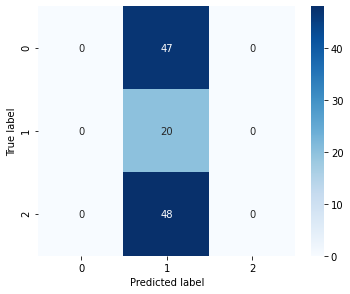

[[ 0 47  0]
 [ 0 20  0]
 [ 0 48  0]]


In [21]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

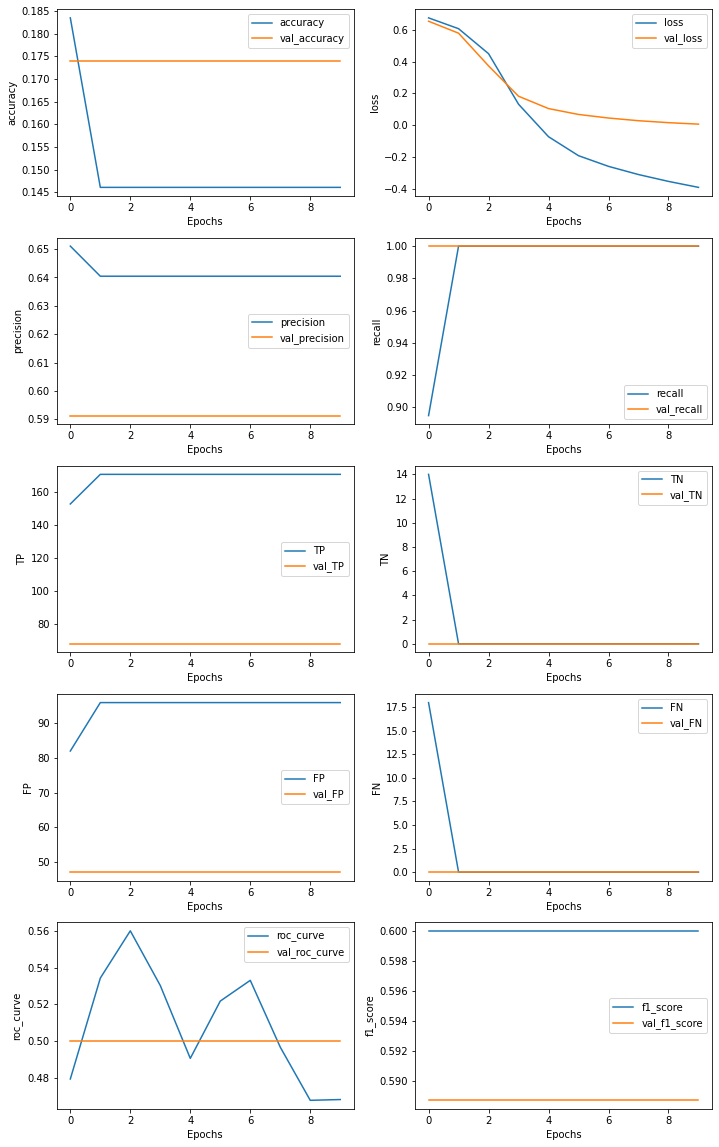

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


# **Test**

In [0]:
import json
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Define Hyper parameter
vocab_size = 25000
embedding_dim = 32 
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


texts = []
labels = []
evaluations = []

# remove where "Text" = "" & "Language" = "en"
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['orientation']
    evaluation = item['evaluation']

    if( label == '1' or label == '2') : label = 1
    elif(label == '0') : label = 0
    else : label = -1

    if(item['text']!="" and item['lan']!="en"):

      for word in stopwords:
        token = " " + word + " " ; 
        text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)
      evaluations.append(int(evaluation))

print(len(texts))
print(len(labels)) 
print(len(evaluations)) 

random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_eval = evaluations[0:training_size]
testing_eval = evaluations[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

training_eval = np.array(training_eval)
testing_eval = np.array(testing_eval)

--2020-05-06 18:41:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>] 579.69K  3.09MB/s    in 0.2s    

2020-05-06 18:41:57 (3.09 MB/s) - ‘/tmp/reviews.json’ saved [593600/593600]

382
382
382
training size :  267
testing size :  115


In [0]:
print(training_padded.shape)
print(training_labels.shape)
print(training_eval.shape)

(267, 500)
(267,)
(267,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed4e1ee9e8>]],
      dtype=object)

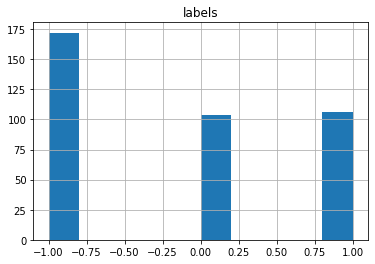

In [0]:
import pandas as pd
# data = pd.DataFrame(evaluations, columns = ['evaluations'])
data = pd.DataFrame(labels, columns = ['labels'])
data.hist()

In [0]:
num_eval = 3  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title') 
# body_input = keras.Input(shape=(None,), name='body')  
eval_input = keras.Input(shape=(num_eval,), name='evaluation') 

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)


# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)


# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, eval_input])


# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, eval_input],
                    outputs=[ department_pred])
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

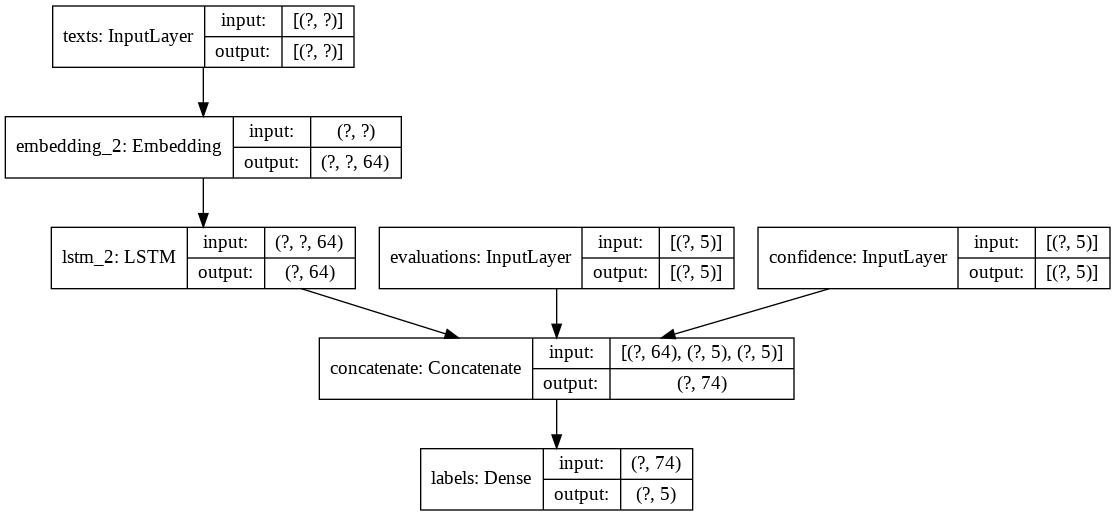

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

num_eval = 5
evals = [-2, -1, 0, 1, 2] 
num_labels = 5
labels = [-2,-1, 0, 1, 2]
num_conf = 5
conf = [1, 2, 3, 4, 5] 
num_words = 10000  

text_input = keras.Input(shape=(None,), name='texts')  
eval_input = keras.Input(shape=(num_eval,), name='evaluations') 
cof_input = keras.Input(shape=(num_conf,), name='confidence') 

# Embed each word in the title into a 64-dimensional vector
text_features = layers.Embedding(num_words, 64)(text_input)
text_features = layers.LSTM(64)(text_features)

x = layers.concatenate([text_features, eval_input, cof_input])

lebel_pred = layers.Dense(num_labels, name='labels')(x)

model = keras.Model(inputs=[text_input, eval_input, cof_input], outputs=lebel_pred)

keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'labels': keras.losses.CategoricalCrossentropy(from_logits=True)},
              metrics= ['accuracy'],
              loss_weights=[1., 0.2])

In [0]:
a = np.array([1, 2, 3, 4, 5, 6])
a.shape

(6,)

In [0]:
b = 0
for i in range(5):
  temp = b
  b = np.expand_dims(a, axis=1)
  print(b.shape)
b = np.expand_dims(a, axis=1)
c = np.expand_dims(b, axis=1)
d = np.expand_dims(c, axis=1)
e = np.expand_dims(d, axis=1)
print(e.shape)


(6, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1, 1, 1, 1)


In [0]:


# history = model.fit({'texts' : training_padded, 'evaluations' : training_eval}, 
#                     {'labels' : training_labels}, epochs=num_epochs, 
#           validation_data=({'texts' : testing_padded, 'evaluations' : testing_eval}, {'labels' : testing_labels}), 
#           verbose = 0)

model.fit({'texts' : training_padded, 'evaluations' : training_eval},
           {'labels' : training_labels},
          validation_data=({'texts' : testing_padded, 'evaluations' : testing_eval}, {'labels' : testing_labels}),
          epochs=2,
          batch_size=32)


Epoch 1/2


ValueError: ignored

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
])

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))

# losses = tf.losses.sigmoid_cross_entropy(
#         multi_class_labels=tf.squeeze(tf.one_hot(labels, depth=2), axis=1),
#         logits=logits)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), verbose = 3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 32)           800000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                153616    
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 51        
Total params: 953,667
Trainable params: 953,667
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


ValueError: ignored

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()
